In [1]:
import os
import pandas as pd
import numpy as np
import langdetect

In [2]:
# Get the path to the folder containing the Excel files
excel_folder_path = "../raw/WorldCup_Countries_Embassies_in_Qatar"

# Create a list of all the Excel files in the folder
excel_files = []
for file in os.listdir(excel_folder_path):
    if file.endswith(".xlsx"):
        excel_files.append(file)

In [3]:
# Create a dictionary to store the results
results = {}
all_global_embassies_df = pd.DataFrame()

# Helper function to catch errors
def detect_language(text):
    try:
        return langdetect.detect(text)
    except:
        return "undetected"

# Loop over all of the Excel files
for excel_file in excel_files:
    # Read the Excel file into a Pandas DataFrame
    df = pd.read_excel(excel_folder_path + "/" + excel_file)

    # Get the total number of tweets
    total_tweets = df.shape[0]

    # Get the total number of original tweets
    # If RTed column is empty then it is an original tweet
    original_tweets = df[df["RTed"].isna()].shape[0]

    # Get the total number of retweets
    retweets = total_tweets - original_tweets

    # Get unique date (not time) values from the created_at column
    # Convert the created_at column to datetime format
    df["created_at"] = pd.to_datetime(df["created_at"])
    # Get the unique date values
    unique_dates = df["created_at"].dt.date.unique()
    # Convert the unique_dates to strings
    unique_dates = unique_dates.astype(str)

    # Apply langdetect.detect() to each text in the df['text'] column and write the result to the df['languages'] column if it exists, if value does not exist then write "undetected"
    df['languages'] = df['text'].apply(lambda x: detect_language(x) if x else "undetected")
    # Refer to this page to get the list of ISO 639-1 codes:https://en.wikipedia.org/wiki/List_of_ISO_639-1_codes

    # For each text in the df['text'] column if the text contains '#' then split the words and get the first word which is the hashtag
    df['hashtags'] = df['text'].apply(lambda x: x.split()[0] if x and '#' in x else np.nan) 

        # Convert specified columns to string dtype
    columns_to_convert = ['media1', 'media2', 'media3', 'media4']
    df[columns_to_convert] = df[columns_to_convert].astype(str)

    # Check if media URLs start with 'https://pbg' and create corresponding columns
    has_image_columns = ['hasImage1', 'hasImage2', 'hasImage3', 'hasImage4']
    df[has_image_columns] = df[columns_to_convert].apply(lambda x: x.str.contains('jpg')).fillna(False)

    # Check if media URLs start with 'https://video' and create corresponding columns
    has_video_columns = ['hasVideo1', 'hasVideo2', 'hasVideo3', 'hasVideo4']
    df[has_video_columns] = df[columns_to_convert].apply(lambda x: x.str.contains('mp4')).fillna(False)

    # Create 'hasImage' column by checking if any of the 'hasImage' columns are True
    df['hasImage'] = df[has_image_columns].any(axis=1)

    # Create 'hasVideo' column by checking if any of the 'hasVideo' columns are True
    df['hasVideo'] = df[has_video_columns].any(axis=1)

     
    # Get country from excel_file name
    country = excel_file.split(" ")[0]
    
    # Add the results to the dictionary
    results[country] = {
        "total_tweets": total_tweets,
        "original_tweets": original_tweets,
        "retweets": retweets,
        "unique_dates": unique_dates,
        "languages": df['languages'].unique(), 
        "hashtags": df['hashtags'].unique(), 
        "hasImages": df[df['hasImage'] == True].shape[0],
        "hasVideos": df[df['hasVideo'] == True].shape[0],
    }

    # Concatenate the DataFrame to the all_data DataFrame
    all_global_embassies_df = pd.concat([all_global_embassies_df, df], ignore_index=True)

# Create a DataFrame from the dictionary
df_results = pd.DataFrame(results)

In [4]:
# Set id column as index 
all_global_embassies_df.set_index('id', inplace=True)

In [5]:
# Export df_results as an excel file 
df_results.to_excel('../interim/global_embassies_stats.xlsx')
all_global_embassies_df.to_excel('../interim/all_global_embassies.xlsx')

In [6]:
sum_total_tweets = df_results.iloc[0].sum()
print(f"Total tweets: {sum_total_tweets}")

Total tweets: 2459


In [7]:
print(f"Total tweets: {all_global_embassies_df.shape[0]}")
print(f"Total retweets: {all_global_embassies_df[all_global_embassies_df['rt'] > 0].shape[0]}")
print(f"Total number of tweets liked at least once: {all_global_embassies_df[all_global_embassies_df['fav'] > 0].shape[0]}")

Total tweets: 2459
Total retweets: 2046
Total number of tweets liked at least once: 1056


In [8]:
# Convert created_at column to datetime
all_global_embassies_df['created_at'] = pd.to_datetime(all_global_embassies_df['created_at'])
# Get the date value only from created_at column
all_global_embassies_df['created_at_date'] = all_global_embassies_df['created_at'].dt.date

all_global_embassies_df = all_global_embassies_df.sort_values(by='created_at_date') # Sort by created_at_date 

Text(0, 0.5, 'Count')

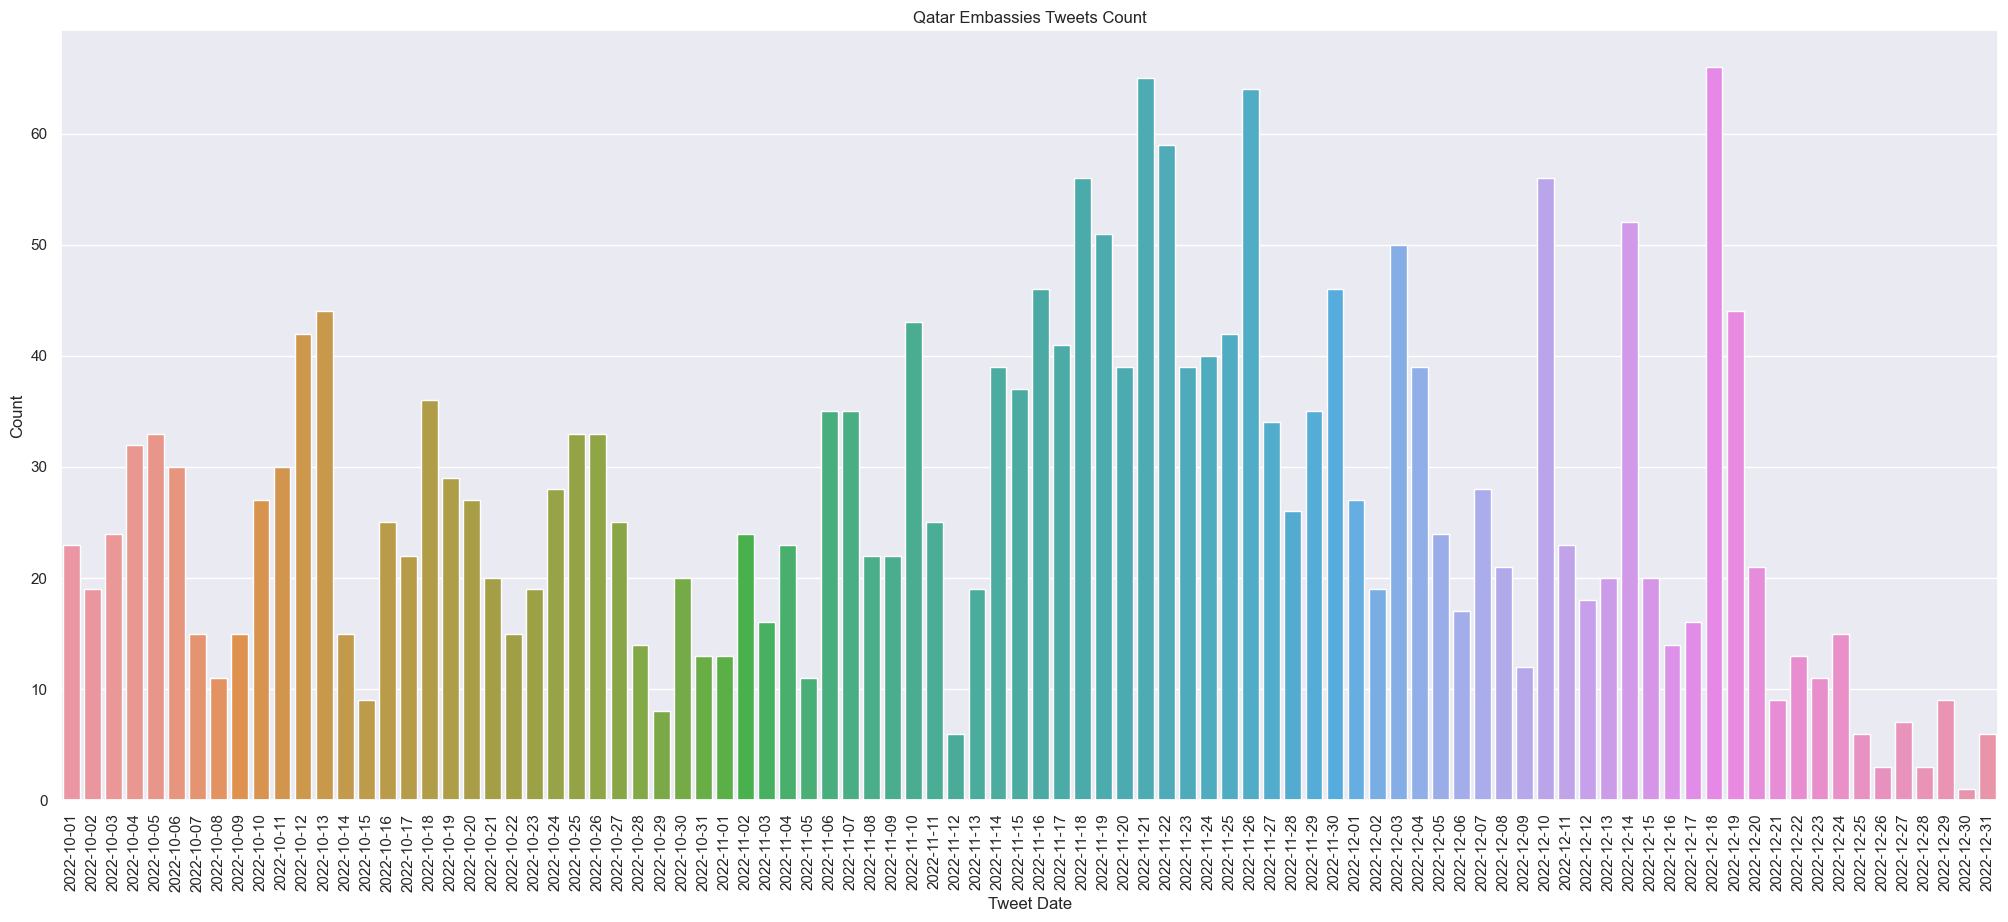

In [9]:
import seaborn as sns 
import matplotlib.pyplot as plt

sns.set_style("dark") # Setting style for seaborn plot
sns.set(rc={'figure.figsize':(25,10)}) # Setting size of plot

sns.countplot(data=all_global_embassies_df, x="created_at_date") # Prepare a countplot 

plt.title("Qatar Embassies Tweets Count") # Set title for plot
plt.xticks(rotation=90) # rotate the x axis labels
plt.xlabel("Tweet Date") # set x-axis label
plt.ylabel("Count") # set y-axis label